In [1]:
from pathlib import Path
import pandas as pd

wt_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20.ehull.csv.gz"), index_col="folder_ind")
diffcsp_data = pd.read_csv(Path("generated", "DiffCSP_mp_20_NO_RELAX.ehull.csv.gz"), index_col=0)
wt_diffcsppp_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20_DiffCSP++_NO_RELAX.ehull.csv.gz"), index_col="folder_ind")

In [2]:
import gzip
import pickle
from wyckoff_transformer.evaluation import StatisticalEvaluator
with gzip.open(Path("cache", "mp_20", "data.pkl.gz"), "rb") as f:
    datasets_pd = pickle.load(f)
evaluator = StatisticalEvaluator(datasets_pd["test"], pd.concat([datasets_pd["train"], datasets_pd["val"]], axis=0))

In [3]:
from itertools import repeat
from ast import literal_eval
GENERATED_PATH = Path("generated")

In [4]:
import json
from typing import Dict
with gzip.open(GENERATED_PATH / "WyckoffTransformer_mp_20.json.gz", "rt") as f:
    generated_wyckoff_transformer = pd.read_json(f)
with gzip.open(GENERATED_PATH / "DiffCSP_mp_20.sites.json.gz", "rt") as f:
    generated_diffcsp = pd.read_json(f)

def check_novelty_record(record: Dict) -> bool:
    return evaluator.generated_to_fingerprint(record) not in evaluator.train_fingerprints
generated_wyckoff_transformer["is_novel"] = generated_wyckoff_transformer.apply(check_novelty_record, axis=1)
generated_diffcsp["is_novel"] = generated_diffcsp.apply(check_novelty_record, axis=1)


In [5]:
wt_data["is_novel"] = generated_wyckoff_transformer["is_novel"]
wt_diffcsppp_data["is_novel"] = generated_wyckoff_transformer["is_novel"]
wt_data = wt_data[wt_data["is_novel"]]
wt_diffcsppp_data = wt_diffcsppp_data[wt_diffcsppp_data["is_novel"]]

In [6]:
diffcsp_data["is_novel"] = generated_diffcsp["is_novel"]
diffcsp_data = diffcsp_data[diffcsp_data["is_novel"]]

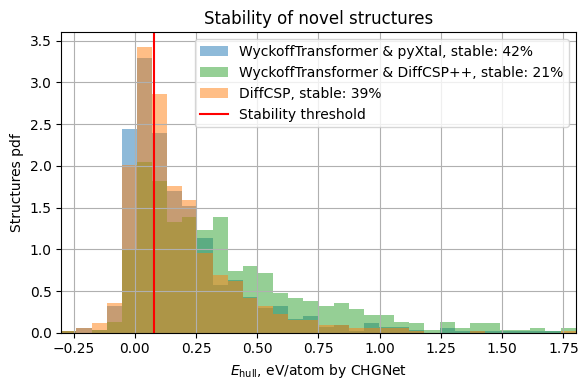

In [7]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))
bins=np.linspace(-0.3, 1.8, 35)
stability_threshold = 0.08
wt_data.corrected_chgnet_ehull.hist(bins=bins, ax=ax,
    label=f"WyckoffTransformer & pyXtal, stable: {100*(wt_data.corrected_chgnet_ehull <= stability_threshold).sum()/len(wt_data):.0f}%",
    color="tab:blue", density=True, alpha=0.5)
wt_diffcsppp_data.corrected_chgnet_ehull.hist(bins=bins, ax=ax,
    label=f"WyckoffTransformer & DiffCSP++, stable: {100*(wt_diffcsppp_data.corrected_chgnet_ehull <= stability_threshold).sum()/len(wt_diffcsppp_data):.0f}%",
    color="tab:green", density=True, alpha=0.5)
diffcsp_data.corrected_chgnet_ehull.hist(bins=bins, ax=ax,
    label=f"DiffCSP, stable: {100*(diffcsp_data.corrected_chgnet_ehull <= stability_threshold).sum()/len(diffcsp_data):.0f}%",
    color="tab:orange", density=True, alpha=0.5)
ax.set_xlabel("$E_\\text{hull}$, eV/atom by CHGNet")
ax.set_ylabel("Structures pdf")
ax.axvline(stability_threshold, color="red", label="Stability threshold")
ax.set_xlim((-0.3, 1.8))
ax.set_title("Stability of novel structures")
ax.legend()
fig.tight_layout()
fig.savefig("plots/AI4AM_NeurIPS_2024/MP_20_stability.pdf")